In [1]:
import urllib
import pandas as pd
import numpy as np
from sklearn import datasets

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import xarray as xr
import scipy.interpolate as interp

import scipy.io as sio
import numpy.matlib
import cmath

In [2]:
# Choose iceberg year (2002 - 2015 available)
# Note: Iceberg Season starts in November so many datasets include dates from year-1
season_year = 2015
iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
iip_filename = f'IIP_{season_year}IcebergSeason.csv'
iip_url = iip_url_base + iip_filename
r = urllib.request.urlretrieve(iip_url)
df = pd.read_csv(r[0], converters={'TIME':str})
df['DATETIME'] = pd.to_datetime(df['DATE'] + 'T' + df['TIME'])

In [3]:
# Choose the min number of observations for an eligible iceberg
min_num_obs = 10
eligible_bergs = np.asarray(
    df['BERG_NUMBER'].value_counts()\
    .loc[df['BERG_NUMBER'].value_counts() > min_num_obs].index)

In [4]:
chosen_inds_arr = []

for i in range(eligible_bergs.size):

    berg_id = eligible_bergs[i]
    berg_df = df.loc[df['BERG_NUMBER'] == berg_id]
    
    ind0 = berg_df.index.tolist()[0]
    indf = berg_df.index.tolist()[-1]
    
    max_time_dif = np.timedelta64(24*60*3, 'm')
    
    chosen_inds = []

    for j in range(len(berg_df)-1):

        time_dif = (berg_df.DATETIME.values[j+1] - \
                    berg_df.DATETIME.values[j]).astype('timedelta64[m]')
        
        if time_dif < max_time_dif:
            chosen_inds.append(j+ind0)

        elif len(chosen_inds) > 5:
            chosen_inds_arr.append(chosen_inds)
            chosen_inds = []
        else:
            chosen_inds = []

    if len(chosen_inds) > 5:
        chosen_inds_arr.append(chosen_inds)

In [5]:
# Choose which iceberg track to look at (index)
chosen_track_ind = 2

berg_df = df.loc[chosen_inds_arr[chosen_track_ind]].reset_index()

In [69]:
berg_df

,index,ICE-YEAR,BERG_NUMBER,DATE,TIME,LATITUDE,LONGITUDE,METHOD,SIZE,SHAPE,SOURCE,DATETIME
0,4986,2015,21165,6/23/2015,1227,47.67,-48.80,R/V,GEN,GEN,GTJZ,2015-06-23 12:27:00
1,4987,2015,21165,6/23/2015,1914,47.59,-48.81,R/V,GEN,GEN,GTJZ,2015-06-23 19:14:00
2,4988,2015,21165,6/24/2015,1452,47.52,-48.84,R/V,SM,GEN,GTJZ,2015-06-24 14:52:00
3,4989,2015,21165,6/26/2015,1643,47.34,-48.72,R/V,SM,GEN,GMRS,2015-06-26 16:43:00
4,4990,2015,21165,6/27/2015,1116,47.32,-48.72,R/V,SM,GEN,GPGR,2015-06-27 11:16:00
5,4991,2015,21165,6/28/2015,1212,47.26,-48.69,R/V,SM,GEN,GTJZ,2015-06-28 12:12:00
6,4992,2015,21165,6/29/2015,1353,47.15,-48.68,R/V,SM,TAB,GPGR,2015-06-29 13:53:00
7,4993,2015,21165,6/30/2015,1113,47.22,-48.50,R/V,SM,GEN,GMRS,2015-06-30 11:13:00
8,4994,2015,21165,6/30/2015,1730,47.32,-48.39,R/V,BB,GEN,GTJZ,2015-06-30 17:30:00
9,4995,2015,21165,7/1/2015,1121,47.27,-48.38,R/V,SM,GEN,GMRS,2015-07-01 11:21:00


In [61]:
class Iceberg:
    
    def __init__(self, id_num, times, lats, lons, size):
        self.id_num = id_num
        self.times = times
        self.times_ref0 = []
        for i in range(len(self.times)):
            self.times_ref0.append(round((self.times[i] - self.times[0]).days*24 + \
                                         (self.times[i] - self.times[0]).seconds/3600, 1))
        self.lats = lats
        self.lons = lons
        
        if type(size) == str:
            self.length, self.width, self.height = self.get_berg_dims(size)
        elif type(size) == list and len(size) == 3:
            self.length, self.width, self.height = size[0], size[1], size[2]
        else:
            print('Invalid size argument')
            
    def get_berg_dims(self, size):
        # Size must be GR, BB, SM, MED, LG, VLG
        # See https://nsidc.org/data/g00807 for more info
        if size == 'GR':
            l = (0+5)/2; w = (0+5)/2; h = (0+1)/2*10
        elif size == 'BB':
            l = (5+15)/2; w = (5+15)/2; h = (1+5)/2*10        
        elif size == 'SM':
            l = (15+60)/2; w = (15+60)/2; h = (5+15)/2*10        
        elif size == 'MED':
            l = (60+120)/2; w = (60+120)/2; h = (15+45)/2*10               
        elif size == 'LG':
            l = (120)/2; w = (120)/2; h = (45+75)/2*10                
        elif size == 'VLG':
            # Sizes have no listed upper bound
            l = (200+200/2)/2; w = (200+200/2)/2; h = (75+75/2)/2*10     
        # This info for GEN is wrong!
        elif size == 'GEN':
            l = (120)/2; w = (120)/2; h = (45+75)/2*10            
        else:
            print('unknown size class')
            l = None; w = None; h = None
        return l, w, h

In [14]:
iip_berg = Iceberg(berg_df['BERG_NUMBER'].loc[0],
                   berg_df['DATETIME'].loc[0:1].tolist(),
                   berg_df['LATITUDE'].loc[0:1].tolist(),
                   berg_df['LONGITUDE'].loc[0:1].tolist(),
                   berg_df['SIZE'].loc[0])

In [15]:
class GLB:
    
    glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'
    
    def __init__(self, berg):
        self.ds = xr.open_dataset(self.glb_url, 
                                  decode_times=False).sel(
                                  depth=0.0, 
                                  lat = slice(min(berg.lats)-1, max(berg.lats)+1), 
                                  lon = slice(min(berg.lons)-1, max(berg.lons)+1), 
                                  time = slice(self.convert_time(berg.times[0]), 
                                               self.convert_time(berg.times[-1], add_day=True)))
        self.times = np.asarray(self.ds.time)
        self.times_ref0 = self.times - self.times[0]
        self.lats = np.asarray(self.ds.lat)
        self.lons = np.asarray(self.ds.lon)
        self.water_u = np.asarray(self.ds.water_u)
        self.water_v = np.asarray(self.ds.water_v)
        self.water_temp = np.asarray(self.ds.water_temp)
        
    def convert_time(self, berg_time, add_day = False):
        date2000 = np.datetime64('2000-01-01')
        diff = berg_time - date2000
        days = diff.days
        #seconds = diff.seconds
        if add_day:
            hours = (days+1)*24
        else:
            hours = days*24
        return hours

In [16]:
glb = GLB(iip_berg)

In [17]:
glb.times_ref0

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.])

In [18]:
class Navgem:
    navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'
    #navgem_url ='http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind'
    #navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D20mWind_LonPM180'
    #navgem_url ='http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem1D10mWind_LonPM180'
    
    def __init__(self, berg):
        self.ds = xr.open_dataset(self.navgem_url).sel(
                         time=slice(self.convert_time(berg.times[0]), 
                                    self.convert_time(berg.times[-1], add_day=True)), 
                         latitude=slice(min(berg.lats)-1, max(berg.lats)+1), 
                         longitude=slice(min(berg.lons)-1, max(berg.lons)+1))
        self.times = np.asarray(self.ds.time)
        self.lats = np.asarray(self.ds.latitude)
        self.lons = np.asarray(self.ds.longitude)
        #self.wind_u = np.asarray(self.ds.wnd_ucmp_height_above_ground)
        #self.wind_v = np.asarray(self.ds.wnd_vcmp_height_above_ground)
            
    def convert_time(self, berg_time, add_day=False):
        if add_day:
            one_day = pd.Timedelta('1 days')
            date = '{}-{}-{}' .format((berg_time + one_day).year,
                                      (berg_time + one_day).month,
                                      (berg_time + one_day).day)
        else:
            date = '{}-{}-{}' .format(berg_time.year,
                                      berg_time.month,
                                      berg_time.day)
        return date

In [19]:
#navgem = Navgem(iip_berg)

In [20]:
class NOAA:
    noaa_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOw6hrP_LonPM180'
    
    # Warning: u,v values are all nan at 00:00:00 of each day
    
    def __init__(self, berg):
        self.ds = xr.open_dataset(self.noaa_url).sel(
                         time=slice(self.convert_time(berg.times[0]), 
                                    self.convert_time(berg.times[-1], add_day=True)),
                         altitude=10.0,
                         latitude=slice(min(berg.lats)-1, max(berg.lats)+1), 
                         longitude=slice(min(berg.lons)-1, max(berg.lons)+1))
        self.times = np.asarray(self.ds.time[3:])
        self.lats = np.asarray(self.ds.latitude)
        self.lons = np.asarray(self.ds.longitude)
        self.wind_u = np.asarray(self.ds.u[3:])
        self.wind_v = np.asarray(self.ds.v[3:])
            
    def convert_time(self, berg_time, add_day=False):
        one_day = pd.Timedelta('1 days')

        if add_day:
            date = '{}-{}-{}' .format((berg_time + one_day).year,
                                      (berg_time + one_day).month,
                                      (berg_time + one_day).day)
        else:
            date = '{}-{}-{}' .format((berg_time - one_day).year,
                                      (berg_time - one_day).month,
                                      (berg_time - one_day).day)  # first time is nan
        return date

In [21]:
#noaa = NOAA(iip_berg)

In [22]:
def convert_time(berg_time, add_day=False):
    one_day = pd.Timedelta('1 days')

    if add_day:
        date = '{}-{}-{}' .format((berg_time + one_day).year,
                                  (berg_time + one_day).month,
                                  (berg_time + one_day).day)
    else:
        date = '{}-{}-{}' .format((berg_time).year,
                                  (berg_time).month,
                                  (berg_time).day)  # first time is nan
    return date

In [23]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'
navgem_ds = xr.open_dataset(navgem_url)
navgem_ds = navgem_ds.sel(
                 time=slice(convert_time(iip_berg.times[0]), 
                            convert_time(iip_berg.times[-1], add_day=True)), 
                 latitude=slice(min(iip_berg.lats)-1, max(iip_berg.lats)+1), 
                 longitude=slice(min(iip_berg.lons)-1, max(iip_berg.lons)+1))
navgem_times = np.asarray(navgem_ds.time)
navgem_lats = np.asarray(navgem_ds.latitude)
navgem_lons = np.asarray(navgem_ds.longitude)
navgem_wind_u = np.asarray(navgem_ds.wnd_ucmp_height_above_ground)
navgem_wind_v = np.asarray(navgem_ds.wnd_vcmp_height_above_ground)
navgem_ds.close()

In [24]:
navgem_wind_u = navgem_wind_u[:,0,:,:]
navgem_wind_v = navgem_wind_v[:,0,:,:]

In [25]:
# must change navgem_times to numeric type for interpolator
date2000 = np.datetime64('2000-01-01')
one_hour = np.timedelta64(1, 'h')
navgem_times = (navgem_times - date2000).astype('timedelta64[h]')/one_hour
navgem_times_ref0 = navgem_times - navgem_times[0]

In [26]:
navgem_times_ref0

array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.])

In [27]:
navgem_times

array([ 135648.,  135654.,  135660.,  135666.,  135672.,  135678.,
        135684.,  135690.])

## Make interpolants

In [37]:
water_u_interp = interp.RegularGridInterpolator((glb.times_ref0, glb.lats, glb.lons), glb.water_u)
water_v_interp = interp.RegularGridInterpolator((glb.times_ref0, glb.lats, glb.lons), glb.water_v)
water_temp_interp = interp.RegularGridInterpolator((glb.times_ref0, glb.lats, glb.lons), glb.water_temp)

In [38]:
wind_u_interp = interp.RegularGridInterpolator((navgem_times_ref0, navgem_lats, navgem_lons), navgem_wind_u)
wind_v_interp = interp.RegularGridInterpolator((navgem_times_ref0, navgem_lats, navgem_lons), navgem_wind_v)

## Iceberg Model

In [39]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [40]:
def iceDEF(t,x,y,l,w,h):

    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]
    
    
    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)

    
    if lam < 0.1:
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

        
    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    return x_new, y_new, l_new, w_new, h_new   

In [41]:
# Model Timesteps
t0 = iip_berg.times_ref0[0]
tf = iip_berg.times_ref0[-1]
tstep = 0.1
t_all = np.arange(t0, tf + tstep, tstep)
dt = tstep*3600  # timestep in seconds

In [62]:
mod_berg = Iceberg(berg_df['BERG_NUMBER'].loc[0],
                   [berg_df['DATETIME'].loc[0]],
                   [berg_df['LATITUDE'].loc[0]],
                   [berg_df['LONGITUDE'].loc[0]],
                   berg_df['SIZE'].loc[0])

In [63]:
mod_berg.length = [mod_berg.length]
mod_berg.width = [mod_berg.width]
mod_berg.height = [mod_berg.height]

In [64]:
# Iceberg Initial Location
x0, y0 = mod_berg.lons[0], mod_berg.lats[0]

# Run number
run_num = 0
num_runs = 1

# Buffer number for bounding spatial box
buf = 0.5

# Manual stop time
#stop_time = 36
stop_time = tf

# Initialize output dict
output_dict = {}

for run_num in range(num_runs):
    
    # Iceberg Initials
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
    l0 = l0 + l0*0.1*run_num
    w0 = w0 + w0*0.1*run_num
    h0 = h0 + h0*0.1*run_num
    l, w, h = l0, w0, h0
    x, y = x0, y0
    t = t0
    #iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))
    
    while t < stop_time:
        
        #print('Timestep: {}'.format(t))

        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

        if x_new > max(iip_berg.lons)+buf or x_new < min(iip_berg.lons)-buf or y_new > max(iip_berg.lats)+buf or y_new <= min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += tstep
            t = round(t, 1)
            #iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            mod_berg.times.append(t)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.length.append(l)
            mod_berg.width.append(h)
            #iceberg = np.column_stack((iceberg, iceberg_new))

    print("Final time: {}".format(t))

Run number: 0, h = 600.0, l = 60.0, w = 60.0
rollover
swap l and w
Final time: 6.8


## Plots

In [65]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import bisect

In [66]:
def plot1(iip_berg, mod_berg):    
    plt.plot(iip_berg.lats, iip_berg.lons, label='observed')
    plt.plot(mod_berg.lats, mod_berg.lons, label='computed')
    plt.legend()
    plt.xlabel('Latitude'); plt.ylabel('Longitude')
    plt.title('Iceberg Drift')
    plt.savefig('./drift_track1.png')
    plt.show()

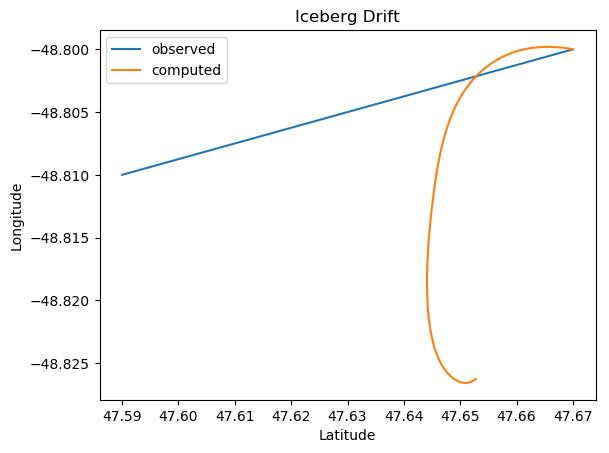

In [67]:
plot1(iip_berg, mod_berg)